In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_wavelets import DWTForward, DWTInverse
import matplotlib.pyplot as plt

In [2]:
class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir, transform=None):
        self.ct_files = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.png')])
        self.mri_files = sorted([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.endswith('.png')])
        self.transform = transform
        
        # Ensure we have matching pairs by taking the minimum length
        min_len = min(len(self.ct_files), len(self.mri_files))
        self.ct_files = self.ct_files[:min_len]
        self.mri_files = self.mri_files[:min_len]
        
        print(f"Dataset initialized with {len(self.ct_files)} CT files and {len(self.mri_files)} MRI files")

    def __len__(self):
        return len(self.ct_files)

    def __getitem__(self, idx):
        ct = cv2.imread(self.ct_files[idx], cv2.IMREAD_GRAYSCALE)
        mri = cv2.imread(self.mri_files[idx], cv2.IMREAD_GRAYSCALE)

        ct = ct.astype(np.float32)/255.
        mri = mri.astype(np.float32)/255.

        # Add channel dim
        ct = np.expand_dims(ct, axis=0)
        mri = np.expand_dims(mri, axis=0)

        if self.transform:
            ct = self.transform(ct)
            mri = self.transform(mri)

        return torch.tensor(ct), torch.tensor(mri)

# Example usage
# dataset = CTMRIDataset('data/ct','data/mri')
# loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [3]:
class WaveletFusionNetSpatial(nn.Module):
    def __init__(self, wave='haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)
        self.idwt = DWTInverse(wave=wave)
        self.mask_net = nn.Sequential(
            nn.Conv2d(2,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,4,3,padding=1), nn.Sigmoid()
        )

    def forward(self, ct, mr):
        # --- Ensure 4D ---
        if ct.dim() == 3: ct = ct.unsqueeze(0)
        if mr.dim() == 3: mr = mr.unsqueeze(0)

        # --- DWT decomposition ---
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # --- Split high-frequency channels ---
        # ct_high[0] has shape [batch, channels, 3, H, W] - need to properly index
        ct_lh, ct_hl, ct_hh = ct_high[0][:,:,0:1,:,:], ct_high[0][:,:,1:2,:,:], ct_high[0][:,:,2:3,:,:]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,:,0:1,:,:], mr_high[0][:,:,1:2,:,:], mr_high[0][:,:,2:3,:,:]
        
        # Squeeze the extra dimension to get [batch, channels, H, W]
        ct_lh, ct_hl, ct_hh = ct_lh.squeeze(2), ct_hl.squeeze(2), ct_hh.squeeze(2)
        mr_lh, mr_hl, mr_hh = mr_lh.squeeze(2), mr_hl.squeeze(2), mr_hh.squeeze(2)

        # --- Low-frequency mask input ---
        low_stack = torch.cat([ct_low, mr_low], dim=1)
        # Keep mask computation at low-frequency resolution
        masks_low = self.mask_net(low_stack)
        mL, mLH_small, mHL_small, mHH_small = masks_low[:,0:1], masks_low[:,1:2], masks_low[:,2:3], masks_low[:,3:4]
        
        # Resize high-frequency masks to match high-frequency component dimensions
        high_freq_size = (ct_lh.shape[2], ct_lh.shape[3])
        mLH = F.interpolate(mLH_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHL = F.interpolate(mHL_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHH = F.interpolate(mHH_small, size=high_freq_size, mode='bilinear', align_corners=False)

        # --- Fuse low-frequency ---
        # Keep the low frequency at its original size (half of input size) for inverse DWT
        fused_low = mL*ct_low + (1-mL)*mr_low

        # --- Fuse high-frequency ---
        fused_lh = mLH*ct_lh + (1-mLH)*mr_lh
        fused_hl = mHL*ct_hl + (1-mHL)*mr_hl
        fused_hh = mHH*ct_hh + (1-mHH)*mr_hh
        
        # Stack them back to the original format for inverse DWT
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)

        # --- Inverse DWT ---
        fused = self.idwt((fused_low, [fused_high]))
        return fused

In [4]:
class FusionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
    
    def forward(self, fused, ct, mr):
        # Keep gradients through fused
        loss_ct = self.l1(fused, ct)
        loss_mr = self.l1(fused, mr)
        return loss_ct + loss_mr

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
dataset = CTMRIDataset('Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT','Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI')
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, loss, optimizer
model = WaveletFusionNetSpatial().to(device)
criterion = FusionLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
epochs = 5
for ep in range(epochs):
    for i,(ct,mr) in enumerate(loader):
        ct, mr = ct.to(device), mr.to(device)
        optimizer.zero_grad()
        fused = model(ct,mr)
        loss = criterion(fused, ct, mr)
        loss.backward()
        optimizer.step()
        if i%5==0:
            print(f'Epoch [{ep+1}/{epochs}], Step [{i}/{len(loader)}], Loss: {loss.item():.4f}')

Dataset initialized with 160 CT files and 160 MRI files
Epoch [1/5], Step [0/80], Loss: 0.1358
Epoch [1/5], Step [5/80], Loss: 0.1735
Epoch [1/5], Step [10/80], Loss: 0.1292
Epoch [1/5], Step [15/80], Loss: 0.1362
Epoch [1/5], Step [20/80], Loss: 0.1808
Epoch [1/5], Step [25/80], Loss: 0.2088
Epoch [1/5], Step [30/80], Loss: 0.1388
Epoch [1/5], Step [35/80], Loss: 0.1423
Epoch [1/5], Step [40/80], Loss: 0.1639
Epoch [1/5], Step [45/80], Loss: 0.1405
Epoch [1/5], Step [50/80], Loss: 0.1492
Epoch [1/5], Step [55/80], Loss: 0.1676
Epoch [1/5], Step [60/80], Loss: 0.1356
Epoch [1/5], Step [65/80], Loss: 0.1652
Epoch [1/5], Step [70/80], Loss: 0.1598
Epoch [1/5], Step [75/80], Loss: 0.2189
Epoch [2/5], Step [0/80], Loss: 0.1693
Epoch [2/5], Step [5/80], Loss: 0.1381
Epoch [2/5], Step [10/80], Loss: 0.1538
Epoch [2/5], Step [15/80], Loss: 0.1741
Epoch [2/5], Step [20/80], Loss: 0.1556
Epoch [2/5], Step [25/80], Loss: 0.1777
Epoch [2/5], Step [30/80], Loss: 0.1374
Epoch [2/5], Step [35/80], L

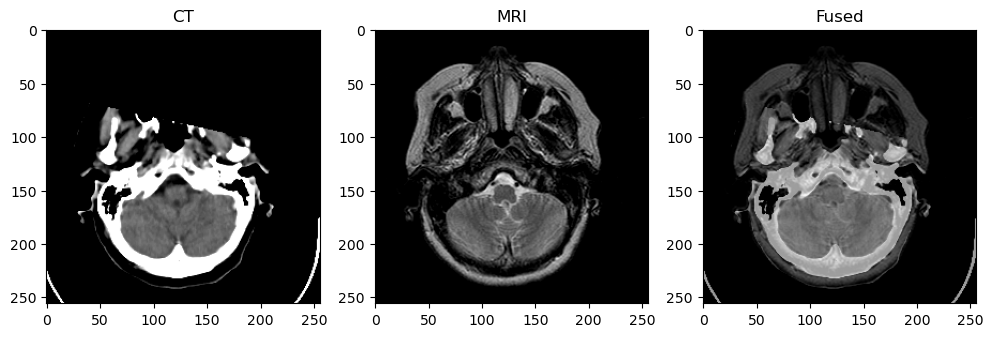

In [6]:
model.eval()
with torch.no_grad():
    ct,mr = dataset[0]
    ct, mr = ct.unsqueeze(0).to(device), mr.unsqueeze(0).to(device)
    fused = model(ct,mr)
    fused_img = fused.squeeze().cpu().numpy()
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(ct.squeeze().cpu(), cmap='gray'); plt.title('CT')
    plt.subplot(1,3,2); plt.imshow(mr.squeeze().cpu(), cmap='gray'); plt.title('MRI')
    plt.subplot(1,3,3); plt.imshow(fused_img, cmap='gray'); plt.title('Fused')
    plt.show()
